In [1]:
import pandas as pd
df1=pd.read_excel('UDJG_ADULT_CONS1.xls')
df2=pd.read_excel('UDJG_ADULT_CONS2.xls')
df3=pd.read_excel('UDJG_ADULT_CONS3.xls')
df4=pd.read_excel('UDJG_ADULT_CONS4.xls')
dataset2=pd.read_excel('UDJG_ADULT_FOODS.xls')
dataset3=pd.read_excel('UDJG_ADULT_SUBJ.xls')

dataset = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)
#dataset = pd.read_excel('UDJG_ADULT_CONS1.xls')

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import os
import seaborn as sns
import random
from collections import Counter
import numpy as np

In [3]:
columns_to_delete=['SURVEY', 'CONDAY', 'CONMONTH', 'CONYEAR', 'EXCEPTIONDAY', 'TIMEHOUR', 
                   'TIMEMINUTES', 'UNITMEAS', 'BRAND', 'ORFACETSCODE', 'ORFACETS', 'ENFACETS', 'PACKAGE', 'OFACETS', 'ORRECIPECODE', 
                   'ENRECIPEDESC', 'AMOUNTRECIPE', 'FPREP', 'FOODEXRCODE']
dataset=dataset.drop(columns=columns_to_delete, axis=1)


columns_to_delete2=['SURVEY', 'COMMENTSFOOD', 'ENERGY', 'WATER', 'FAT', 'CARB', 'PROTEINS', 'ALCOHOL', 'ENFOODNAME', 'FOODEXCODE']
dataset2=dataset2.drop(columns=columns_to_delete2, axis=1)

columns_to_delete3=['SURVEY', 'COUNTRY', 'BIRTHDAY', 'BIRTHMONTH', 'BIRTHYEAR', 'FANTYEAR', 'SWEIGHT', 'SHEIGHT', 'SANTDAY', 'SANTMONTH', 'SANTYEAR', 'MWEIGHT', 
                    'MHEIGHT', 'ENRGYINTAKE', 'UNOVREP', 'WF', 'SPECIALCON', 'SPECDIET', 'ACTIVITY', 'ETHNIC', 'FANTMONTH', 'FANTDAY',
                    'EDUCATION', 'COMMENTSSUBJECT']
dataset3=dataset3.drop(columns=columns_to_delete3, axis=1)

In [4]:
dataset.head(10)

,ORSUBCODE,DAY,WEEK,SEASON,MEAL,PLACE,EATSEQ,ORRECIPEDESC,ORFOODCODE,AMOUNTFRAW,AMOUNTFCOOKED
0,F001,1,W1,S5,M1,P3,1,NaN,207.1.1.6.0,25.0,25.0
1,F001,1,W1,S5,M1,P3,1,NaN,204.1.2.5.0,25.0,25.0
2,F001,1,W1,S5,M1,P3,2,NaN,101.1.1.1.0,250.0,250.0
3,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),204.2.2.2.1,3.0,3.0
4,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),414.0.0.0.1,100.0,100.0
5,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),108.1.1.1.0,50.0,36.5
6,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),204.2.1.3.0,30.0,25.2
7,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),204.2.1.8.0,40.0,32.8
8,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),206.1.2.0.0,5.0,15.0
9,F001,1,W1,S5,M3,P3,1,ciorba de perisoare (cu vegeta),110.1.0.0.0,20.0,20.0


In [5]:
columns_to_check_duplicates = ['ORSUBCODE', 'DAY', 'WEEK', 'SEASON', 'MEAL', 'PLACE', 'EATSEQ']
condition_not_empty = dataset['ORRECIPEDESC'].notna()

dataset_no_duplicates = dataset[condition_not_empty].drop_duplicates(subset=columns_to_check_duplicates, keep='first')
dataset_no_duplicates = pd.concat([dataset[~condition_not_empty], dataset_no_duplicates])

In [6]:
dataset_no_duplicates.head(10)

,ORSUBCODE,DAY,WEEK,SEASON,MEAL,PLACE,EATSEQ,ORRECIPEDESC,ORFOODCODE,AMOUNTFRAW,AMOUNTFCOOKED
0,F001,1,W1,S5,M1,P3,1,NaN,207.1.1.6.0,25.0,25.0
1,F001,1,W1,S5,M1,P3,1,NaN,204.1.2.5.0,25.0,25.0
2,F001,1,W1,S5,M1,P3,2,NaN,101.1.1.1.0,250.0,250.0
24,F001,1,W1,S5,M3,P3,2,NaN,207.1.1.6.0,50.0,50.0
27,F001,1,W1,S5,M7,P3,1,NaN,414.1.5.1.0,75.0,75.0
28,F001,1,W1,S5,M7,P3,2,NaN,204.1.1.9.0,100.0,100.0
51,F001,2,W2,S5,M3,P3,2,NaN,108.2.2.2.17,121.0,85.0
52,F001,2,W2,S5,M3,P3,2,NaN,207.1.1.6.0,25.0,25.0
53,F001,2,W2,S5,M5,P3,1,NaN,101.1.2.0.1,175.0,175.0
54,F001,2,W2,S5,M7,P3,1,NaN,204.1.1.2.0,118.0,118.0


In [7]:
foodcode_to_recipe = dataset2.set_index('ORFOODCODE')['ORFOODNAME'].to_dict()

mask = pd.isna(dataset_no_duplicates['ORRECIPEDESC'])
dataset_no_duplicates.loc[mask, 'ORRECIPEDESC'] = dataset_no_duplicates.loc[mask, 'ORFOODCODE'].map(foodcode_to_recipe)

dataset_no_duplicates.insert(loc=11, column='GENDER', value='')
dataset_no_duplicates.insert(loc=12, column='AGE', value='')
dataset_no_duplicates.insert(loc=13, column='WEIGHT', value='')
dataset_no_duplicates.insert(loc=14, column='HEIGHT', value='')
dataset_no_duplicates.insert(loc=15, column='GEO', value='')


In [8]:
gender_to_recipe = dataset3.set_index('ORSUBCODE').to_dict()['GENDER']
age_to_recipe = dataset3.set_index('ORSUBCODE').to_dict()['AGE']
weight_to_recipe = dataset3.set_index('ORSUBCODE').to_dict()['WEIGHT']
height_to_recipe = dataset3.set_index('ORSUBCODE').to_dict()['HEIGHT']
geo_to_recipe = dataset3.set_index('ORSUBCODE').to_dict()['GEO']

dataset_no_duplicates.loc[:, 'GENDER'] = dataset_no_duplicates['ORSUBCODE'].map(gender_to_recipe)
dataset_no_duplicates.loc[:, 'AGE'] = dataset_no_duplicates['ORSUBCODE'].map(age_to_recipe)
dataset_no_duplicates.loc[:, 'WEIGHT'] = dataset_no_duplicates['ORSUBCODE'].map(weight_to_recipe)
dataset_no_duplicates.loc[:, 'HEIGHT'] = dataset_no_duplicates['ORSUBCODE'].map(height_to_recipe)
dataset_no_duplicates.loc[:, 'GEO'] = dataset_no_duplicates['ORSUBCODE'].map(geo_to_recipe)


In [9]:
dataset_no_duplicates.loc[:, 'WEEK'] = dataset_no_duplicates['WEEK'].str.replace('W', '').astype(int)
dataset_no_duplicates.loc[:, 'SEASON'] = dataset_no_duplicates['SEASON'].str.replace('S', '').astype(int)
dataset_no_duplicates.loc[:, 'MEAL'] = dataset_no_duplicates['MEAL'].str.replace('M', '').astype(int)
dataset_no_duplicates.loc[:, 'PLACE'] = dataset_no_duplicates['PLACE'].str.replace('P', '').astype(int)
dataset_no_duplicates.loc[:, 'GENDER'] = dataset_no_duplicates['GENDER'].str.replace('G', '').astype(int)
dataset_no_duplicates.loc[:, 'GEO'] = dataset_no_duplicates['GEO'].str.replace('RO', '').astype(int)

In [10]:
columns_to_delete=['ORFOODCODE', 'ORSUBCODE']
dataset_no_duplicates=dataset_no_duplicates.drop(columns=columns_to_delete, axis=1)


In [11]:
le = LabelEncoder()
#dataset['ORRECIPEDESC'] = le.fit_transform(dataset['ORRECIPEDESC'])
dataset_no_duplicates['ORRECIPEDESC_encoded'] = le.fit_transform(dataset_no_duplicates['ORRECIPEDESC'])


In [12]:
dataset_no_duplicates['BMI'] = np.ceil((dataset_no_duplicates['WEIGHT'] / (dataset_no_duplicates['HEIGHT'] / 100) ** 2) ) # * 10) / 10

In [13]:
dataset_no_duplicates.head()

,DAY,WEEK,SEASON,MEAL,PLACE,EATSEQ,ORRECIPEDESC,AMOUNTFRAW,AMOUNTFCOOKED,GENDER,AGE,WEIGHT,HEIGHT,GEO,ORRECIPEDESC_encoded,BMI
0,1,1,5,1,3,1,paine,25.0,25.0,2,34,64.0,164,126,1183,24
1,1,1,5,1,3,1,dulceata,25.0,25.0,2,34,64.0,164,126,692,24
2,1,1,5,1,3,2,lapte,250.0,250.0,2,34,64.0,164,126,912,24
24,1,1,5,3,3,2,paine,50.0,50.0,2,34,64.0,164,126,1183,24
27,1,1,5,7,3,1,cafea preparata,75.0,75.0,2,34,64.0,164,126,171,24


In [14]:
#dataset_no_duplicates=dataset_no_duplicates.sample(frac=1, random_state=42)
#dataset_no_duplicates.reset_index(drop=True, inplace=True)
dataset_no_duplicates.to_csv('Dataset.csv')

In [15]:
interest = dataset_no_duplicates.iloc[:, [col for col in range(dataset_no_duplicates.shape[1]) if col != 6]].values

# standardize data (mean = 0, std dev = 1)
scaler = StandardScaler()
interest_z = scaler.fit_transform(interest)

In [32]:
# apply k-means
random.seed(2345)

kmeans = KMeans(init="random", n_clusters=5, n_init=10, max_iter=300,random_state=42)
kmeans = KMeans(n_clusters=10)
kmeans.fit(interest_z)

kmeans.n_iter_
kmeans.cluster_centers_

dataset_no_duplicates['cluster'] = kmeans.labels_
Counter(dataset_no_duplicates['cluster'])

C:\Users\ca222\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Counter({8: 12098,
         7: 11858,
         2: 11547,
         9: 11377,
         0: 10908,
         5: 9894,
         1: 9576,
         3: 9060,
         6: 5060,
         4: 1714})

In [33]:

# presupunem că aveți un DataFrame numit dataset_no_duplicates

def classify_bmi(row):
    bmi = row['BMI']
    if bmi < 16:
        return 'Severe Thinness'
    elif 16 <= bmi < 17:
        return 'Moderate Thinness'
    elif 17 <= bmi < 18.5:
        return 'Mild Thinness'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    elif 30 <= bmi < 35:
        return 'Obese Class I'
    elif 35 <= bmi < 40:
        return 'Obese Class II'
    elif bmi >= 40:
        return 'Obese Class III'
    else:
        return 'Unknown'  # pentru valorile NaN sau nevalide

# Aplicarea funcției de clasificare
dataset_no_duplicates['WeightClassification'] = dataset_no_duplicates.apply(classify_bmi, axis=1)


In [38]:
# Gruparea datelor și calcularea frecvenței fiecărei rețete în fiecare cluster și GEO
popular_recipes = dataset_no_duplicates.groupby(['cluster', 'AGE'])['ORRECIPEDESC'].value_counts()

# Obținerea top 5 rețete pentru fiecare combinație de cluster și GEO
top5_recipes_per_cluster_geo = popular_recipes.groupby(level=[0, 1]).nlargest(1).reset_index(level=[0, 1], drop=True)

# Afișarea rezultatelor
top5_recipes_per_cluster_geo.to_csv('statistica1.csv')

In [39]:
dataset_no_duplicates


,DAY,WEEK,SEASON,MEAL,PLACE,EATSEQ,ORRECIPEDESC,AMOUNTFRAW,AMOUNTFCOOKED,GENDER,AGE,WEIGHT,HEIGHT,GEO,ORRECIPEDESC_encoded,BMI,cluster,WeightClassification
0,1,1,5,1,3,1,paine,25.000,25.00000,2,34,64.0,164,126,1183,24,7,Normal
1,1,1,5,1,3,1,dulceata,25.000,25.00000,2,34,64.0,164,126,692,24,7,Normal
2,1,1,5,1,3,2,lapte,250.000,250.00000,2,34,64.0,164,126,912,24,7,Normal
24,1,1,5,3,3,2,paine,50.000,50.00000,2,34,64.0,164,126,1183,24,7,Normal
27,1,1,5,7,3,1,cafea preparata,75.000,75.00000,2,34,64.0,164,126,171,24,7,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257880,4,4,3,5,1,1,cartofi taranesti,314.286,216.85700,1,22,60.0,175,424,317,20,2,Normal
257890,5,5,3,3,1,1,ciorba de varza cu carne,266.666,133.33300,1,22,60.0,175,424,498,20,8,Normal
257908,6,6,3,1,1,3,cartofi la cuptor cu costita,178.042,122.84900,1,22,60.0,175,424,300,20,8,Normal
257914,6,6,3,3,1,2,supa de vita,41.436,41.43600,1,22,60.0,175,424,1808,20,8,Normal


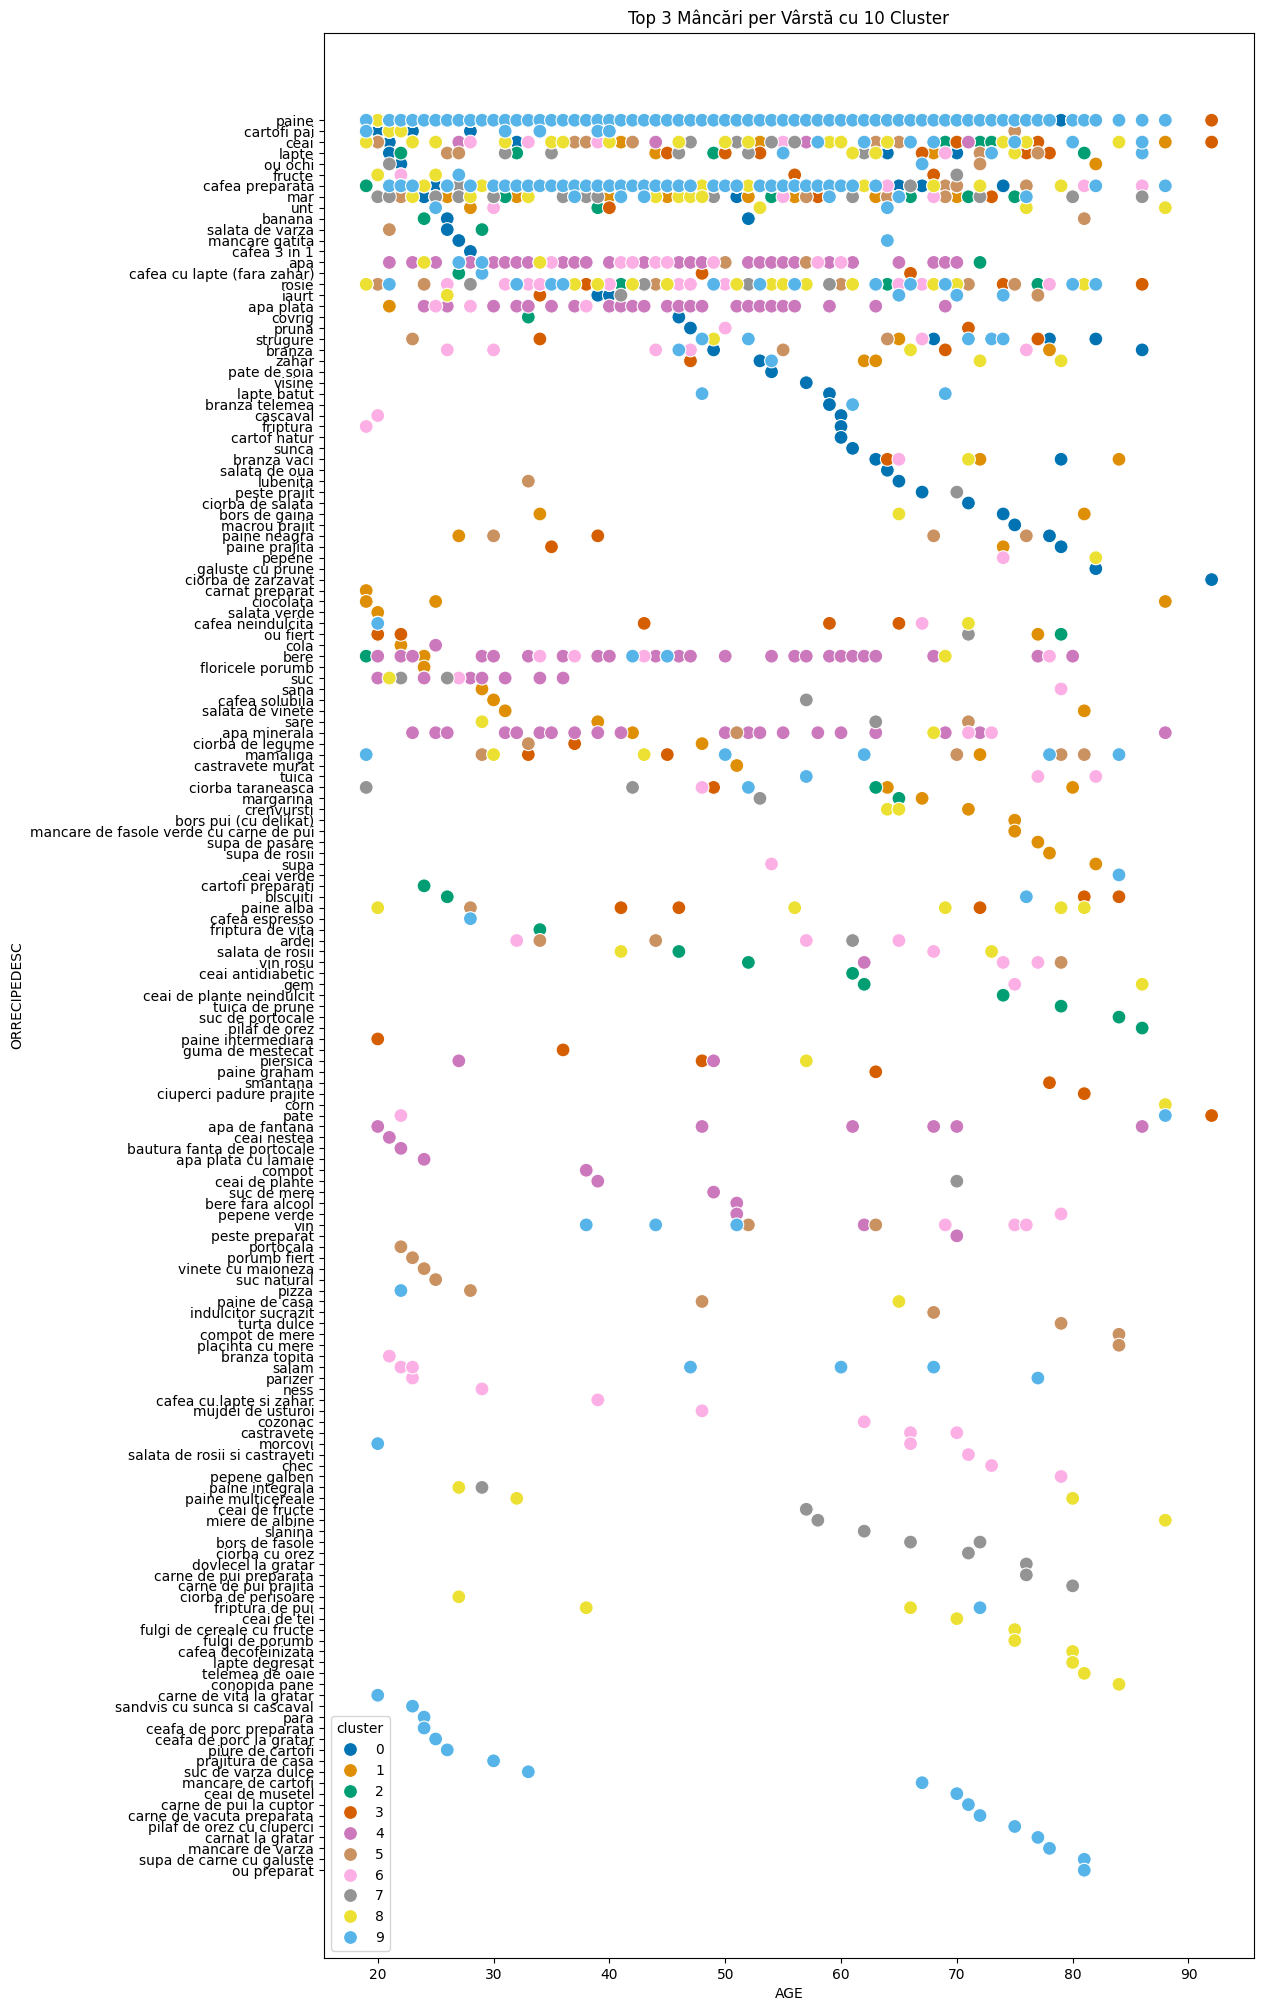

In [40]:

# Presupunând că aveți un DataFrame numit dataset_no_duplicates

# Definirea unei funcții pentru extragerea top 3 cele mai frecvente mâncări
def get_top3_most_frequent(series):
    return series.value_counts().head(3).index.tolist()

# Calcularea top 3 cele mai populare mâncări pentru fiecare combinație de vârstă și cluster
top3_per_age_cluster = dataset_no_duplicates.groupby(['cluster', 'AGE'])['ORRECIPEDESC'].apply(get_top3_most_frequent)

# Resetarea indexului pentru a transforma seria într-un DataFrame
top3_per_age_cluster = top3_per_age_cluster.reset_index()

# Explodarea listei de mâncări pentru a avea fiecare mâncare pe un rând separat
top3_per_age_cluster = top3_per_age_cluster.explode('ORRECIPEDESC')

# Setarea dimensiunii graficului
plt.figure(figsize=(12, 25))

# Definirea unei palete de culori personalizate
palette = sns.color_palette("colorblind", n_colors=len(top3_per_age_cluster['cluster'].unique()))

# Crearea graficului scatterplot cu paleta de culori personalizată
sns.scatterplot(x='AGE', y='ORRECIPEDESC', hue='cluster', data=top3_per_age_cluster, s=100, palette=palette)

# Setarea titlului
plt.title('Top 3 Mâncări per Vârstă cu 10 Cluster')

# Afișarea graficului
plt.show()



In [41]:
# Calculul procentajului pentru top 10 grupe de vârstă
top10_age_counts = dataset_no_duplicates['AGE'].value_counts(normalize=True).head(10) * 100

# Calculul procentajului pentru top 10 mâncări
top10_recipes_counts = dataset_no_duplicates['ORRECIPEDESC'].value_counts(normalize=True).head(10) * 100

# Afișarea rezultatelor
print("Procentajul pentru top 10 grupe de vârstă:")
for age, percentage in top10_age_counts.items():
    print(f"{age}: {percentage:.2f}%")

# Afișarea procentajului pentru top 10 mâncări cu două zecimale și simbolul procentului
print("Procentajul pentru top 10 mâncări:")
for recipe, percentage in top10_recipes_counts.items():
    print(f"{recipe}: {percentage:.2f}%")


Procentajul pentru top 10 grupe de vârstă:
38: 3.56%
60: 3.40%
58: 3.35%
36: 3.33%
42: 3.32%
40: 3.31%
45: 3.27%
37: 3.25%
56: 3.02%
43: 2.93%
Procentajul pentru top 10 mâncări:
paine: 14.26%
cafea preparata: 5.45%
rosie: 2.83%
mar: 2.43%
ceai: 2.36%
lapte: 1.73%
apa: 1.31%
branza: 1.11%
strugure: 1.09%
unt: 1.08%
